Copy of [`The-more-you-look-the-less-you-find.ipynb`](https://github.com/giacomov/giacomov.github.io/blob/master/notebooks/The-more-you-look-the-less-you-find.ipynb) of Giacomo Vianello. Notebook underlying his [Medium article] (https://towardsdatascience.com/precision-and-recall-trade-off-and-multiple-hypothesis-testing-family-wise-error-rate-vs-false-71a85057ca2b) to put it on mybinder.

Import everything what has been previously in the cell at the end of the notebook:

In [1]:
cd c:\Users\kzl465\Documents\CBPP\CriticalThinking\Discussion Session 4_ Statistics and Study Bias\multiple_testing_example

c:\Users\kzl465\Documents\CBPP\CriticalThinking\Discussion Session 4_ Statistics and Study Bias\multiple_testing_example


In [2]:
%matplotlib inline
from utils import * # originally in a cell at the end of the notebook

In [3]:
#%load utils.py

In [4]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

# Multiple hypothesis testing, or "the more you look the less you find"

In this post I study different methods of correcting for multiple hypothesis testing, which occurs often in practice when searching for anomalies in multiple datasets or for example when making catalogs in Astronomy.

Let's start from the basics and illustrate what does it mean to have multiple tests.

> NOTE: this notebook is available for download in my [GitHub repository](https://github.com/giacomov/giacomov.github.io/tree/master/notebooks). If you have suggestion/edits, feel free to open an issue or send a pull request there. _If you are running this notebook_, first you need to execute the last cell, which contains the helper code

In this post I assume familiarity with some concepts, in particular statistical tests, null vs alternative hypothesis, p-value, type I error and type II errors. If you need a refresher, look in your favorite textbook or on [Wikipedia](https://en.wikipedia.org/wiki/Type_I_and_type_II_errors).

Roughly speaking, a statistical test is something capable of either rejecting or not the null hypothesis with a given type I error probability $\alpha$ (probability of a false positive) and a type II error probability $\beta$ (probability of a false negative).

## Our toy problem

Let's consider the problem of determining whether two populations have the same average or not. The null hypothesis is that the average is the same, the alternative is that it is not. 

Note that you can substitute this problem with any other problem answerable with a statistical test and all the discussion here will still hold (but of course you need to rework the code).

## Simple case: one test

The test appropriate for the problem at hand is the [Student's T-test](http://195.134.76.37/applets/AppletTtest/Appl_Ttest2.html). Let's write the function that computes the p-value and a function that decides whether the null is rejected or not based on the p-value:

In [5]:
# Let's write so that w1 and w2 can be lists of n
# datasets, from 1 to as much as needed
def apply_ttest(w1, w2):
    
    ts, pvalues = scipy.stats.ttest_ind(w1, w2, axis=1)

    return np.squeeze(pvalues)

# The null is accepted if all the pvalues are larger 
# than alpha (global null hypothesis, see below)
def null_hyp_status(pvalue, alpha):
    
    return np.all(pvalue > alpha)

We now generate 1 dataset with the null hypothesis true, and apply the test. We will use a type I error probability $\alpha=0.05$:

In [6]:
# Let's get a dataset with 1 group and
# the null hypothesis is true
w1, w2, ground_truth = generate_dataset(n_datasets=1, 
                             n_null_true=1)

# Let's now apply the test
alpha = 0.05
pvalue = apply_ttest(w1, w2)

print("Null hyp. is deemed %s" % null_hyp_status(pvalue, alpha))

Null hyp. is deemed True


The test worked as expected, and didn't reject the null hypothesis (which we know is true). Let's verify that the performance of the test is nominal, i.e., that by repeating a large number of independent realizations of the same experiment we reject by chance the null hypothesis with the nominal type I error probability $\alpha$:

In [7]:
# Let's perform 5000 independent simulations
type_I_error_p = measure_rejection_prob(5000, 
                                        apply_ttest, 
                                        null_hyp_status,
                                        alpha, 
                                        n_datasets=1,
                                        n_null_true=1)

print("\nMeasured chance probability of rejecting the "
      "null: %.3f (should be %.3f)" % (type_I_error_p, alpha))

5000 out of 5000 completed (fraction of rejections so far: 0.05)

Measured chance probability of rejecting the null: 0.052 (should be 0.050)


ok, it works as expected.

## Multiple tests

Let's now imagine that we have $m$ pairs of populations, and we want to find out whether one or more pairs have a significant difference between the populations.

The null hypothesis here is "within all pairs, the two populations have the same average", the alternative one is "there is at least one pair where the average is different between the two populations".

Can we just apply the test separately to each pair and see if it rejects for at least one? (spoiler: the answer is no! Also, let's neglect the fact that there are other tests designed for this situation, like ANOVA). Let's see:

In [8]:
# Generate m=50 pairs of populations, all with the same
# average between the populations (the null hypothesis is true)
w1, w2, _ = generate_dataset(n_datasets=50, n_null_true=50)
pvalues = apply_ttest(w1, w2)

print("Null hyp. is deemed %s" % null_hyp_status(pvalues, alpha))

Null hyp. is deemed False


At first this result might come as a suprise. After all, we know that the null hypothesis is true!

However, if you recall the definition of Type I error probability, by fixing $\alpha=0.05$ we are setting up the test so that it will wrongly reject the null with 5% probability. Therefore, by repeating the test 50 times (one for each pair) we had each time a 5% chance of a type I error. The probability of having at least a rejection is hence given by the [Binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution):

In [9]:
# probability of having one or more rejections in 50 trials
m = 50

binomial_distr = scipy.stats.binom(m, alpha)

# NOTE: the .sf method gives the probability of obtaining > 1,
# while we need >= 1, so we add the pmf at 1
prob = binomial_distr.sf(1) + binomial_distr.pmf(1)

print("The prob. of >= 1 false positives in %i "
      "trials is %.3f" % (m, prob))

The prob. of >= 1 false positives in 50 trials is 0.923


There is over 90% chance to get at least one false positive in our setup. Testing multiple times an hypothesis as part of the same question is called "multiple testing" and require some more thoughts.

## Bonferroni / Sidak correction

Bonferroni (1936) introduced a simple correction for situations like this. The prescription is to substitute $\alpha$ for each one of the $m$ independent tests within the composite test with a corrected type I error probability given by the Sidak formula $\alpha^{\prime} = 1 - (1-\alpha)^{1/m}$ (which for large $m$ is often approximated with $\alpha^{\prime} = \alpha / m$). 

> Sometimes in the literature the correction $\alpha^{\prime}=\alpha / m$ is called "Bonferroni correction" while the correction $\alpha^{\prime} = 1 - (1-\alpha)^{1/m}$ is called "Sidak correction". Here we will use the latter formulation, but use the name interceangably as the difference is very small for all practical purposes

The justification for the Sidak formula can be derived very easily and it is a direct consequence of the observation we just did about the Binomial distribution. The probability $\alpha$ of obtaining 1 or more successes in $m$ trials with probability $\alpha^{\prime}$ is given by $1 - B(m, p=\alpha^{\prime}, k=0)$, where $B(m, p=\alpha^{\prime}, k=0)$ is the probability of obtaining 0 successes given by the Binomial distribution. We have then:

$$
\alpha = 1 - \frac{m!}{k!(m-k)!} \alpha^{\prime k} (1 - \alpha^{\prime})^{n-k} = 1 - (1 - \alpha^{\prime})^{m}
$$

where we have just substituted $k=0$. Solving for $\alpha^{\prime}$ we obtain the type I error probability that we need to use in each of the $m$ tests to obtain a global type I error probability of $\alpha$, which is the Bonferroni/Sidak correction.

> NOTE: we assume independent tests. If there is correlation between the different tests, the methods presented here might or might not apply, you need to look closer at the relevant papers.

Let's see if this solves our problem. We just need to change the criterium used to decide whether to reject or not the null, no need to change the computation of the p-values:

In [10]:
# Test if any of the pvalues is lower than alpha',
# if the answer yes, the null hyp. is deemed False
def null_hyp_status_bonferroni(pvalues, alpha):
    
    # Number of tests
    m = pvalues.shape[0]
    
    # Bonferroni/Sidak correction
    alpha_prime = 1 - (1-alpha)**(1.0/m)
    
    # Test whether *all* null hypothesis in the subtests are
    # true or not
    return np.all(pvalues > alpha_prime)

w1, w2, _ = generate_dataset(n_datasets=50, n_null_true=50)
pvalues = apply_ttest(w1, w2)

print("Null hyp. is deemed %s" % null_hyp_status_bonferroni(pvalues, alpha))

Null hyp. is deemed True


That looks better. In order to make sure, let's generate a lot of synthetic datasets as earlier and let's see if our Bonferroni-corrected test provides the nominal type I error probability $\alpha=0.05$:

In [11]:
# Let's do again 5000 realization of datasets with 50
# pairs where the null is true for all pairs,
# and study the performance of the new procedure
type_I_error_p = measure_rejection_prob(5000, 
                                        apply_ttest, 
                                        null_hyp_status_bonferroni,
                                        alpha, 
                                        n_datasets=50,
                                        n_null_true=50)

print("\nMeasured chance probability of rejecting the "
      "null: %.3f (should be %.3f)" % (type_I_error_p, alpha))

5000 out of 5000 completed (fraction of rejections so far: 0.05)

Measured chance probability of rejecting the null: 0.047 (should be 0.050)


It worked. The type I error probability is indeed very close to the nominal 5%.

## Issues with Bonferroni-like corrections: Global vs local hypothesis

Until now we were dealing with the "global" null hypothesis, in our case with the problem "is there *any* pair where the average is different between the two populations?". The null hypothesis is that *all* pairs have the same average between the populations, the alternative that one or more has not. 

However, often we are interested in another problem: "find *all* the pairs where the average is different". In this second case, each pair gets its own null and alternative hypothesis and we are interested in how many null hypothesis are rejected.

It is clear that the Bonferroni correction will still guarantee a *global* $\alpha$ type I error probability of rejecting one or more nulls by chance, but it penalizes all tests in order to do so, because $\alpha$ for each test is given by the Sidak formula and $1 - (1-\alpha)^{1/m} < \alpha$ for $m > 1$. 

Moreover, as $m$ grows the global null hypothesis is still tested with the same type I error probability, but each of the $m$ null hypothesis get tested more and more restrictively, and as $m \to \infty$ we have $\alpha^{\prime} \to 0$, so it would be extremely difficult to find any deviation from the null hypothesis. In other words, "the more you look, the less you find".

Let's illustrate this by considering the Type II error of one single test, i.e. the probability of not rejecting the null when we should have. First let's generate and test a pair where the null is false:

In [12]:
# Let's get a dataset with 1 group and
# the null hypothesis is False
w1, w2, ground_truth = generate_dataset(n_datasets=1, n_null_true=0)

# Let's now apply the test
alpha = 0.05
pvalue = apply_ttest(w1, w2)

print("Null hyp. is deemed %s" % null_hyp_status(pvalue, alpha))

Null hyp. is deemed False


We have rigthfully rejected the null hypothesis. Now let's see how many times we fail to reject the null even if it is false over many repetitions of the same experiment (type II error probability):

In [13]:
type_II_error_p = 1 - measure_rejection_prob(5000, 
                                             apply_ttest, 
                                             null_hyp_status,
                                             alpha, 
                                             n_datasets=1,
                                             n_null_true=0)

print("\nMeasured chance probability of *not* rejecting the "
      "null: %.3f" % (type_II_error_p))

5000 out of 5000 completed (fraction of rejections so far: 0.94)

Measured chance probability of *not* rejecting the null: 0.062


So for one test we have a probability of around 6% ($\beta = 0.06$) of *not* rejecting the null even if it is false (of course, $\beta$ depends on $\alpha$ as well as on the size of the effect, in this case the difference between the two averages).

Now let's see what happens if we use the Bonferroni-corrected test on 50 pairs where only one has the null hypothesis false:

In [14]:
type_II_error_p = 1 - measure_rejection_prob(5000, 
                                             apply_ttest, 
                                             null_hyp_status_bonferroni,
                                             alpha, 
                                             n_datasets=50,
                                             n_null_true=49)

print("\nMeasured chance probability of *not* rejecting the "
      "null: %.3f" % (type_II_error_p))

5000 out of 5000 completed (fraction of rejections so far: 0.59)

Measured chance probability of *not* rejecting the null: 0.410


Now we have a 41% probability of *not* rejecting the null when we should have. We clearly have lost a lot of sensitivity now that the difference in one pair is buried in a sample of 50 pairs.

To some extent, this is inevitable and it is the price we pay for not knowing exactly where to look.

However, when trying to test all the *local* null hypothesis instead of the *global* one, things get out of hand very quickly. In order to get an idea, let's make several larger and larger datasets with 50 false null hypothesis each, and see how the type II error changes as a function of the number of pairs/tests $m$:

> NOTE: from now on we will repeatedly use the concepts of [Precision and Recall](https://en.wikipedia.org/wiki/Precision_and_recall). The former describes the fraction of correct "detections" (i.e., null hypothesis rejected) among all detections, i.e., describes the purity of the output sample of our procedure. The latter describes the fraction of null hyp. that we have rejected among the one that we should have rejected (i.e., the completeness of our output sample).

Method bonferroni with alpha 0.05Generating 13 datasets
.............completed


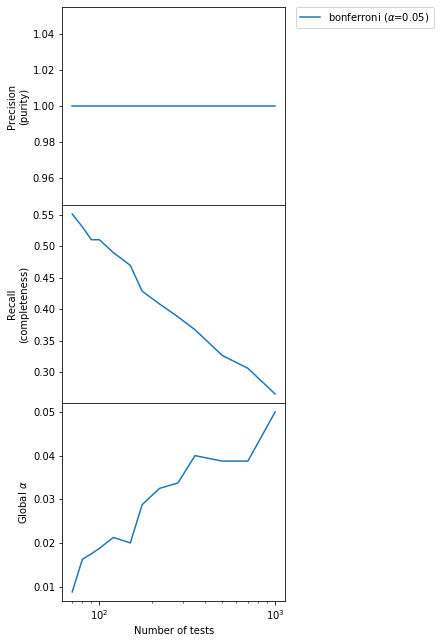

In [15]:
# Test the Bonferroni method with alpha=0.05
methods = [('bonferroni', 0.05)]

# Number of pairs per dataset
ms = np.array([70, 80, 90, 100, 120, 150, 175, 220, 280, 350, 500, 700, 1000])

print("Generating %s datasets" % len(ms))

# Pairs with a false null hypothesis for each dataset
n_false = 50

(selections, 
 false_positives, 
 false_negatives, 
 global_typeI) = characterize_methods(apply_ttest, 
                                      methods, 
                                      ms, 
                                      [n_false] * ms.shape[0], 
                                      niter=800,
                                      plot=True)

We can see that the purity of the output sample is constant to 1.0, but the completeness is small and it also falls very quickly as the number of tests increases. In other words, we are detecting less and less anomalies as $m$ increases but the ones we detect are always correct. The type I error probability of detecting *any* false positive is below the declared $\alpha$ level always, although very conservatively so for small $m$.

Can we do better?

The answer is, fortunately, yes!

## The Holm-Sidak method

There are several corrections that have been proposed to the vanilla Bonferroni/Sidak method. You can find them described [here](https://en.wikipedia.org/wiki/Holm–Bonferroni_method). Without going into the details of each one of them (see the Wikipedia page for that), let's just test them:

Generating 13 datasets
Method bonferroni with alpha 0.05.............completed
Method holm with alpha 0.05.............completed
Method holm-sidak with alpha 0.05.............completed
Method simes-hochberg with alpha 0.05.............completed


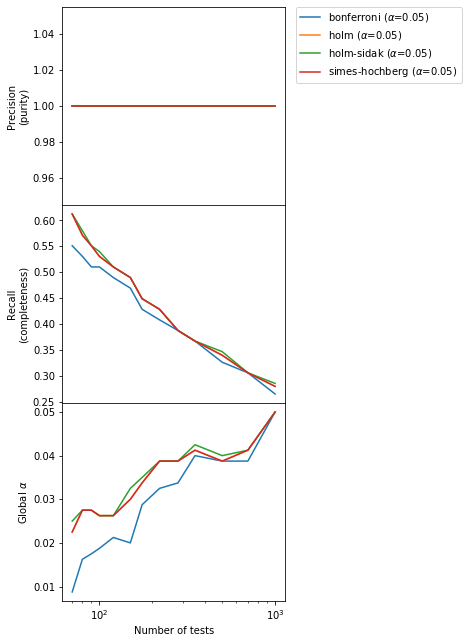

In [16]:
# Test the Bonferroni method with alpha=0.05
methods = [('bonferroni', 0.05), 
           ('holm', 0.05), 
           ('holm-sidak', 0.05),
           ('simes-hochberg', 0.05)]

# Number of pairs per dataset
ms = np.array([70, 80, 90, 100, 120, 150, 175, 220, 280, 350, 500, 700, 1000])

print("Generating %s datasets\n" % len(ms))

# Pairs with a false null hypothesis for each dataset
n_false = 50

(selections, 
 false_positives, 
 false_negatives, 
 global_typeI) = characterize_methods(apply_ttest, 
                                      methods, 
                                      ms, 
                                      [n_false] * ms.shape[0], 
                                      niter=800,
                                      plot=True)

The new methods conserve the absolute purity of the vanilla Bonferroni and a type I error below or at the nominal value, but improve a little bit the completeness. However, we can do a lot better than this! Let's see how.

## False Discovery Rate vs Family-Wise Error Rate

Up to now our solutions to the multiple hypothesis testing problem have been trying to keep under control the FWER, i.e., the rate of type I errors committed in the entire set of $m$ tests (what we called the global $\alpha$ in the plots above). 

However, in the case where we expect several "detections" (i.e., several false null hypothesis) we can sacrifice a little our desire for complete purity and decide that we can accept a controlled amount of false positives if this helps improving sensibly the completeness. In other words, we can accept to have a certain amount of "impostors" in our output sample of detections. This is the idea behind the FDR.

[Benjamini and Holdberg (1995)](https://www.jstor.org/stable/2346101?seq=1#page_scan_tab_contents) presented a procedure that does just that. There, $\alpha$ does not represent anymore the type I error probability, but rather controls the purity of the output sample (i.e., directly affects the Precision instead of the global $\alpha$ as our previous methods). The (expected) Precision is guaranteed to be $> 1 - \alpha$.

As before, we refer to the paper for details. Here I want to illustrate the difference with respect to our earlier methods. Let's use the same procedure as before. For simplicity, let's consider only the best method for our problem among the Boferroni-like ones according to the previous plot ("holm-sidak"):

Method holm-sidak with alpha 0.10.............completed
Method holm-sidak with alpha 0.05.............completed
Method fdr_bh with alpha 0.10.............completed
Method fdr_bh with alpha 0.05.............completed


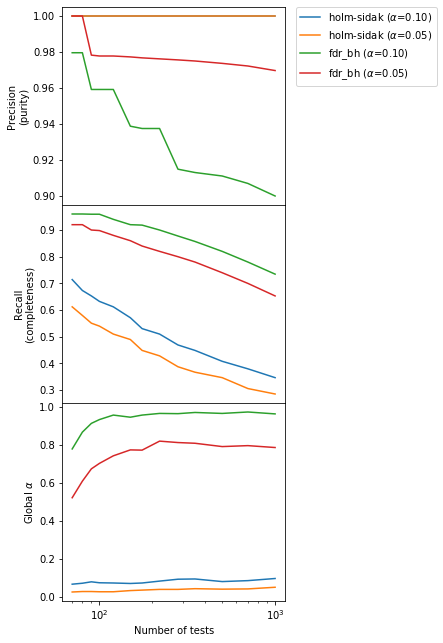

In [17]:
# Let's use two values of alpha per method to illustrate
# what they affect
methods = [('holm-sidak', 0.1), 
           ('holm-sidak', 0.05), 
           ('fdr_bh', 0.1), 
           ('fdr_bh', 0.05)]

# Number of tests
ms = np.array([70, 80, 90, 100, 120, 150, 175, 220, 280, 350, 500, 700, 1000])

# False null hypothesis that we are going to generate
n_false = 50

(selections, 
 false_positives, 
 false_negatives, 
 global_typeI) = characterize_methods(apply_ttest, 
                                      methods, 
                                      ms, 
                                      [n_false] * ms.shape[0], 
                                      niter=800,
                                      plot=True)

We can immediately see that the BH method provides a much larger Recall ("completeness", second panel) by sacrificing a controlled amount  of Precision ("purity"). Indeed, as promised the Precision is $> 1-\alpha$. Going from $\alpha = 0.01$ to $\alpha = 0.05$ in the BH method increases as expected the purity but decreases the completeness. Also, the global $\alpha$ (bottom panel) for the BH method is large and close to 1, which means that in any experiment there is a high probability of getting one or more false positives. This is the price to pay for increasing the completeness, where we gain almost a factor of 2 especially for large and very large number of tests $m$ with respect to Bonferroni-like methods.

Now we understand the key difference between FWER-controlling and FDR-controlling methods: the former put an upper limit $\alpha$ on the FWER ("global" $\alpha$, bottom panel), while the latter put a lower limit $1 - \alpha$ on the Precision ("purity", upper panel).

Up to now we have studied the case where the number of false null hypothesis is constant and the number of tests increases. What happens when the number of false hypothesis increases with the number of tests? This happens for example when we are expanding a search to a previously-unexplored part of the parameter space when we expect the false null hypothesis/anomalies ("sources" in an Astronomical catalog) to have the same density as before.

Method holm-sidak with alpha 0.10.............completed
Method holm-sidak with alpha 0.05.............completed
Method fdr_bh with alpha 0.10.............completed
Method fdr_bh with alpha 0.05.............completed


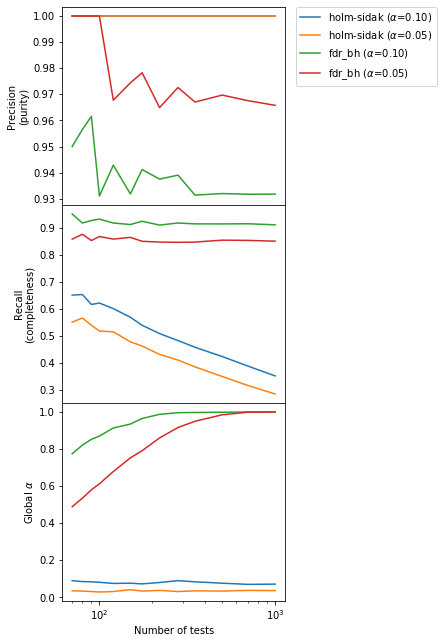

In [18]:
# This time we have 30% of false hypothesis for each
# m
(selections, 
 false_positives, 
 false_negatives, 
 global_typeI) = characterize_methods(apply_ttest, 
                                      methods, 
                                      ms, 
                                      np.ceil(0.3 * ms).astype(int), 
                                      niter=800)

Results are similar as before, but now the completeness for the BH method is essentially constant independently of $m$.

## Conclusion

We have illustrated the problem with multiple hypothesis testing, and two very different methods of dealing with it.

* Methods controling the FWER (like the Bonferroni correction) maximize the Precision ("purity") at the expense of Recall ("completeness" and sensitivity). They are appropriate when the number of expected false null hypothesis/anomalies/detections is small and the price to pay for false positives is high, so purity is more important than completeness. For example, they are very appropriate when looking for the first time for a new effect/new physics, as the expected number of false null hypothesis is at most one and the global null hypothesis really matters. In this case, indeed, making even one false claim is of course very consequential.

* Methods controlling the FDR (like the Benjamini - Hochberg): they increase a lot the completeness with respect to FWER-controlling methods by allowing a controlled amount of false detections to sneak in. They are appropriate when we expect to have several false null hypothesis/anomalies/detections and we can afford to have some false claims. This is typically the situation for catalog works. Using FWER in catalog works introduces a significant [Malmquist bias](https://en.wikipedia.org/wiki/Malmquist_bias) where only very strong effects can be seen.

> NOTE: in this illustrative example we used one single effect size for all false null hypothesis. This is almost never the case in reality, so the distribution of the differences (for example the luminosity function for Astronomical sources) is going to affect obviously the number of anomaly detected. However, the general idea presented here still holds. In the case of an Astronomical catalog, for example, using the FDR instead of the FWER allows to detect fainter sources (increase the sensitivity) at the expenses of some false discoveries.